In [1]:
!pip install kaggle

!kaggle datasets download -d landlord/handwriting-recognition

!unzip handwriting-recognition.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: validation_v2/validation/VALIDATION_5003.jpg  
  inflating: validation_v2/validation/VALIDATION_5004.jpg  
  inflating: validation_v2/validation/VALIDATION_5005.jpg  
  inflating: validation_v2/validation/VALIDATION_5006.jpg  
  inflating: validation_v2/validation/VALIDATION_5007.jpg  
  inflating: validation_v2/validation/VALIDATION_5008.jpg  
  inflating: validation_v2/validation/VALIDATION_5009.jpg  
  inflating: validation_v2/validation/VALIDATION_5010.jpg  
  inflating: validation_v2/validation/VALIDATION_5011.jpg  
  inflating: validation_v2/validation/VALIDATION_5012.jpg  
  inflating: validation_v2/validation/VALIDATION_5013.jpg  
  inflating: validation_v2/validation/VALIDATION_5014.jpg  
  inflating: validation_v2/validation/VALIDATION_5015.jpg  
  inflating: validation_v2/validation/VALIDATION_5016.jpg  
  inflating: validation_v2/validation/VALIDATION_5017.jpg  
  inflating: validation_v2/validation/V

In [2]:
import torch
import tensorflow as tf
import os
import cv2
import imghdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from itertools import chain
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [3]:
# If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Proves Codi 2**

In [4]:
import pandas as pd
import numpy as np
import keras
import keras.layers as L
import keras.models as M
import tensorflow as tf
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2
from keras.utils import Sequence
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.legacy import SGD as LegacySGD  # Use this if you prefer the legacy optimizer
from tensorflow.keras.layers import Layer

In [5]:
train = pd.read_csv('written_name_train_v2.csv')
validation = pd.read_csv('written_name_validation_v2.csv')
#rain_img_dir = 'train_v2/train'
#test_img_dir = 'validation_v2/validation'
#train.head(6), test.head(6)


In [6]:
train.dropna(inplace=True)

In [7]:
train.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [8]:
train['Length']=train['IDENTITY'].apply(lambda x : len(str(x)))
train=train[train['Length']<=21]
train['IDENTITY']=train['IDENTITY'].str.upper()
train[train['Length']==max(train['Length'])]

,FILENAME,IDENTITY,Length
10278,TRAIN_10279.jpg,DOSSANTOS LASCONCELOS,21
108567,TRAIN_108568.jpg,O ZUARRDI EREBEVITRAC,21
156500,TRAIN_156501.jpg,ANDRIANNARISOA--DEGHI,21
160575,TRAIN_160576.jpg,LOUISIANE - EVANGELIN,21
174121,TRAIN_174122.jpg,GU ILLOSSOO - OARRIBA,21
212583,TRAIN_212584.jpg,DE MALEZIEUX DU HAMEL,21
220135,TRAIN_220136.jpg,COSTREL DE CORAINVILL,21
229529,TRAIN_229530.jpg,ROUSSEAV -- CHAUDIERE,21
230011,TRAIN_230012.jpg,BEKNARD DE LAVERNETTE,21
308769,TRAIN_308770.jpg,DATE NAISSANCE CLASSE,21


In [9]:
train=train.sample(frac=0.8,random_state=42)
validation=validation.sample(frac=0.1)

In [10]:
characters=set()
train['IDENTITY']=train['IDENTITY'].apply(lambda x: str(x))
for i in train['IDENTITY'].values:
    for j in i :
        if j not in characters :
            characters.add(j)
characters=sorted(characters)

In [11]:
print(len(characters))

30


In [12]:
# 2 Dictionaries  :   Turn all ur characters to num and vice versa
char_to_label = {char:label for label,char in enumerate(characters)}
label_to_char = {label:char for label,char in enumerate(characters)}

In [13]:
path_train= 'train_v2/train'
path_validation= 'validation_v2/validation'


In [14]:
# Data Generator
class DataGenerator(Sequence):
    def __init__(self,dataframe,path,char_map,batch_size=128,img_size=(256,64),
                 downsample_factor=4,max_length=22,shuffle=True):
        self.dataframe=dataframe
        self.path=path
        self.char_map=char_map
        self.batch_size=batch_size
        self.width=img_size[0]
        self.height=img_size[1]
        self.downsample_factor=downsample_factor
        self.max_length=max_length
        self.shuffle=shuffle
        self.indices = np.arange(len(dataframe))
        self.on_epoch_end()

    def __len__(self):
        return len(self.dataframe)//self.batch_size

    def __getitem__(self,idx):
        curr_batch_idx=self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_images=np.ones((self.batch_size,self.width,self.height,1),dtype=np.float32)
        batch_labels=np.ones((self.batch_size,self.max_length),dtype=np.float32)
        input_length=np.ones((self.batch_size,1),dtype=np.float32)*(self.width//self.downsample_factor-2)
        label_length=np.zeros((self.batch_size,1),dtype=np.int64)
        for i,idx in enumerate(curr_batch_idx):
            img_path=self.dataframe['FILENAME'].values[idx]
            img=cv2.imread(self.path+'/'+img_path)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img=cv2.resize(img,(self.width,self.height))
            img=(img/255).astype(np.float32)
            img=img.T
            img=np.expand_dims(img,axis=-1)
            text=self.dataframe['IDENTITY'].values[idx]
            text=str(text)
            label=[]
            for j in text:
                if j in self.char_map :
                    label.append(self.char_map[j])
                else:
                    label.append(100)
            label.extend([100]*(22-len(label)))
            batch_images[i]=img
            batch_labels[i]=label
            label_length[i]=len(label)
        batch_inputs= {
                'input_data':batch_images,
                'input_label':batch_labels,
                'input_length':input_length,
                'label_length':label_length

            }
        return batch_inputs,np.zeros((self.batch_size),dtype=np.float32)
    def on_epoch_end(self):
        if self.shuffle == True :
            np.random.shuffle(self.indices)

In [15]:
train_generator=DataGenerator(train,path_train,char_to_label)
validation_generator=DataGenerator(validation,path_validation,char_to_label)

In [16]:
# Making CTC Function
class CTCLayer(L.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # On test time, just return the computed loss
        return loss

In [17]:
def make_model():
    inp = L.Input(shape=(256, 64, 1), dtype=np.float32, name='input_data')
    labels = L.Input(shape=[22], dtype=np.float32, name='input_label')
    input_length = L.Input(shape=[1], dtype=np.int64, name='input_length')
    label_length = L.Input(shape=[1], dtype=np.int64, name='label_length')

    x = L.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inp)
    x = L.MaxPooling2D(pool_size=(2, 2))(x)
    x = L.Dropout(0.3)(x)
    x = L.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = L.MaxPooling2D(pool_size=(2, 2))(x)
    x = L.Dropout(0.3)(x)
    new_shape = ((256 // 4), (64 // 4) * 128)
    x = L.Reshape(new_shape)(x)
    x = L.Dense(64, activation='relu')(x)
    x = L.Dropout(0.2)(x)
    x = L.Bidirectional(L.LSTM(128, return_sequences=True, dropout=0.2))(x)
    x = L.Bidirectional(L.LSTM(64, return_sequences=True, dropout=0.25))(x)
    x = L.Dense(len(characters) + 1, activation='softmax', kernel_initializer='he_normal', name='Dense_output')(x)
    output = CTCLayer(name='outputs')(labels, x, input_length, label_length)

    model = Model(inputs=[inp, labels, input_length, label_length], outputs=output)

    sgd = SGD(learning_rate=0.002, momentum=0.9, nesterov=True, clipnorm=5)
    # Alternatively, use the legacy SGD optimizer if needed
    # sgd = LegacySGD(learning_rate=0.002, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

    model.compile(optimizer=sgd,metrics=['accuracy'])

    return model

In [18]:
model=make_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_data (InputLayer)     [(None, 256, 64, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 64, 64)          640       ['input_data[0][0]']          
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 32, 64)          0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 dropout (Dropout)           (None, 128, 32, 64)          0         ['max_pooling2d[0][0]']   

In [19]:
# Add early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   restore_best_weights=True)

# Train the model
if 'prediction_model_ocr.h5' not in os.listdir('./'):
    history = model.fit(train_generator,steps_per_epoch=1000,validation_data=validation_generator,
                        epochs=40)
#history = model.fit(train_generator, epochs=10, batch_size=32, validation_data = validation_generator,  verbose=1)

Epoch 1/40
1000/1000 [==============================] - 271s 242ms/step - loss: 20.5250 - accuracy: 0.0000e+00 - val_loss: 18.8762 - val_accuracy: 0.0000e+00
Epoch 2/40
1000/1000 [==============================] - 235s 235ms/step - loss: 16.5584 - accuracy: 0.0000e+00 - val_loss: 11.4280 - val_accuracy: 0.0000e+00
Epoch 3/40
1000/1000 [==============================] - 236s 236ms/step - loss: 9.1776 - accuracy: 0.0011 - val_loss: 5.8190 - val_accuracy: 0.0159
Epoch 4/40
1000/1000 [==============================] - 230s 230ms/step - loss: 5.9367 - accuracy: 0.0264 - val_loss: 4.0167 - val_accuracy: 0.1340
Epoch 5/40
1000/1000 [==============================] - 231s 230ms/step - loss: 4.4849 - accuracy: 0.0986 - val_loss: 3.1096 - val_accuracy: 0.3101
Epoch 6/40
1000/1000 [==============================] - 236s 236ms/step - loss: 3.6767 - accuracy: 0.1958 - val_loss: 2.6219 - val_accuracy: 0.4441
Epoch 7/40
1000/1000 [==============================] - 230s 230ms/step - loss: 3.1747 - acc

In [20]:
prediction_model = keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='Dense_output').output)
prediction_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_data (InputLayer)     [(None, 256, 64, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 256, 64, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 32, 64)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 32, 64)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 32, 128)      73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 16, 128)       0         
 g2D)                                                      

In [21]:
if 'prediction_model_ocr.h5' not in os.listdir('./'):
    prediction_model.save('prediction_model_ocr.h5')
    prediction_model=M.load_model('prediction_model_ocr.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
label_to_char[100]=''

In [40]:
# A utility to decode the output of the network
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]

    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred,
                                        input_length=input_len,
                                        greedy=True)[0][0]

    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += label_to_char[c]
        output_text.append(outstr)

    # return final text results
    return output_text

4/4 [==============================] - 0s 13ms/step
Ground truth: GROULD 	 Predicted: GROULD
Ground truth: EMIR 	 Predicted: EMIR
Ground truth: JACQUES 	 Predicted: JACQUES
Ground truth: PINARD 	 Predicted: PINARD
Ground truth: BRUNELLO 	 Predicted: BRUNELLO
Ground truth: AMAMOD 	 Predicted: AMAMOU
Ground truth: PASCUAL 	 Predicted: PASCUAL
Ground truth: ELASSIR 	 Predicted: ECASSIR
Ground truth: ENZO 	 Predicted: ENZO
Ground truth: GROUET 	 Predicted: EROWET
Ground truth: LEMEUT 	 Predicted: LEMEUT
Ground truth: CELESTINE 	 Predicted: CELESTINE
Ground truth: JUSTINE 	 Predicted: JUSTINE
Ground truth: SIDI HOHAMED 	 Predicted: SIDI HOHAMED
Ground truth: ALAER 	 Predicted: ALOER
Ground truth: ROO 	 Predicted: ROO
Ground truth: FERRI 	 Predicted: FERRI
Ground truth: MAUNIER 	 Predicted: MAUNIER
Ground truth: CHARLOTTE 	 Predicted: CHARLOTTE
Ground truth: SAHUT-GILLES 	 Predicted: SAMUT-OILLES
Ground truth: HANUS REICHLIN 	 Predicted: HANUS REICHLIN
Ground truth: VALENTIN 	 Predicted: VAL

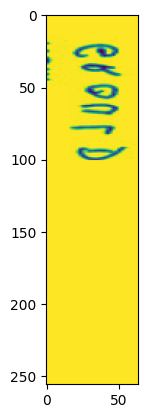

In [41]:
for p, (inp_value, _) in enumerate(validation_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    plt.imshow(X_data[0])
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)


    orig_texts = []
    for label in labels:
        text = ''.join([label_to_char[int(x)] for x in label])
        orig_texts.append(text)
    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    break

In [42]:
def compare_word_pairs(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Las listas deben tener la misma longitud")

    total_pairs = len(list1)
    same_word_count = 0
    same_letter_count = 0
    total_letters = 0

    for word1, word2 in zip(list1, list2):
        if word1 == word2:
            same_word_count += 1

        # Comparar letras
        if len(word1) == len(word2):
            min_length = min(len(word1), len(word2))
            total_letters += min_length
            same_letter_count += sum(1 for a, b in zip(word1, word2) if a == b)

    word_percentage = (same_word_count / total_pairs) * 100
    letter_percentage = (same_letter_count / total_letters) * 100

    return word_percentage, letter_percentage

In [43]:
print(len(orig_texts))
print(len(pred_texts))
word_percentage, letter_percentage = compare_word_pairs(orig_texts, pred_texts)

print(f"Porcentaje de palabras iguales: {word_percentage:.2f}%")
print(f"Porcentaje de letras iguales: {letter_percentage:.2f}%")

128
128
Porcentaje de palabras iguales: 81.25%
Porcentaje de letras iguales: 96.63%


4/4 [==============================] - 0s 13ms/step
Predicted Text: ARABI


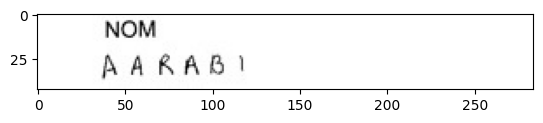

In [44]:
batch_images=np.ones((128,256,64,1),dtype=np.float32)
img=cv2.imread('test_v2/test/TEST_34083.jpg')
img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img=cv2.resize(img,(256,64))
img=(img/255).astype(np.float32)
img=img.T
img=np.expand_dims(img,axis=-1)
batch_images[0]=img
x=prediction_model.predict(batch_images)
pred_texts1 = decode_batch_predictions(x)
pred_texts1 = pred_texts1[0]
im=cv2.imread('test_v2/test/TEST_34083.jpg')
plt.imshow(img)
plt.imshow(im)
print('Predicted Text:',pred_texts1)

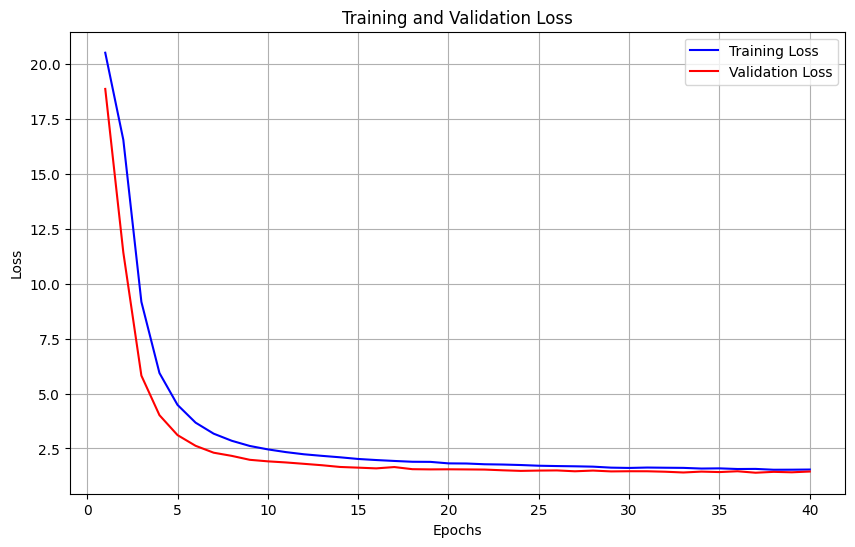

In [45]:

import matplotlib.pyplot as plt

# Obtener los valores de pérdida del historial de entrenamiento
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear un rango de épocas para el eje x
epochs = range(1, len(train_loss) + 1)

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

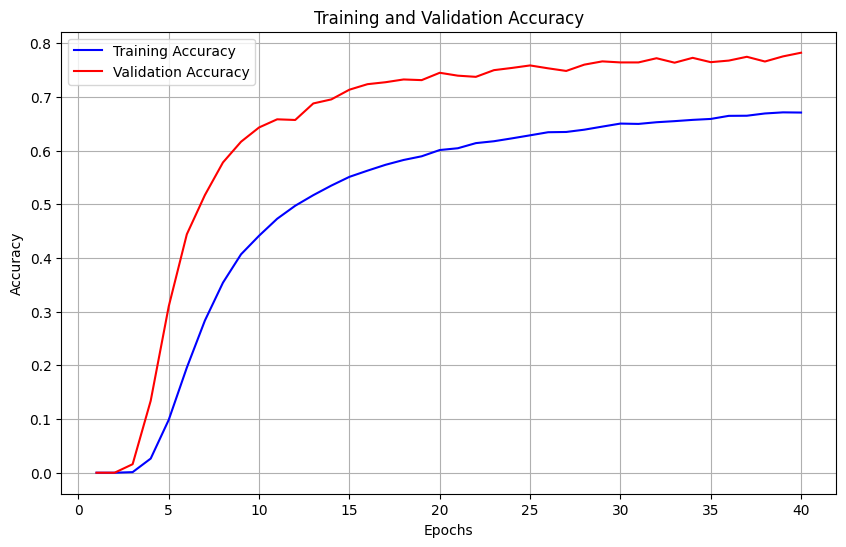

In [46]:
import matplotlib.pyplot as plt

# Obtener los valores de pérdida del historial de entrenamiento
train_loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

# Crear un rango de épocas para el eje x
epochs = range(1, len(train_loss) + 1)

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training Accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

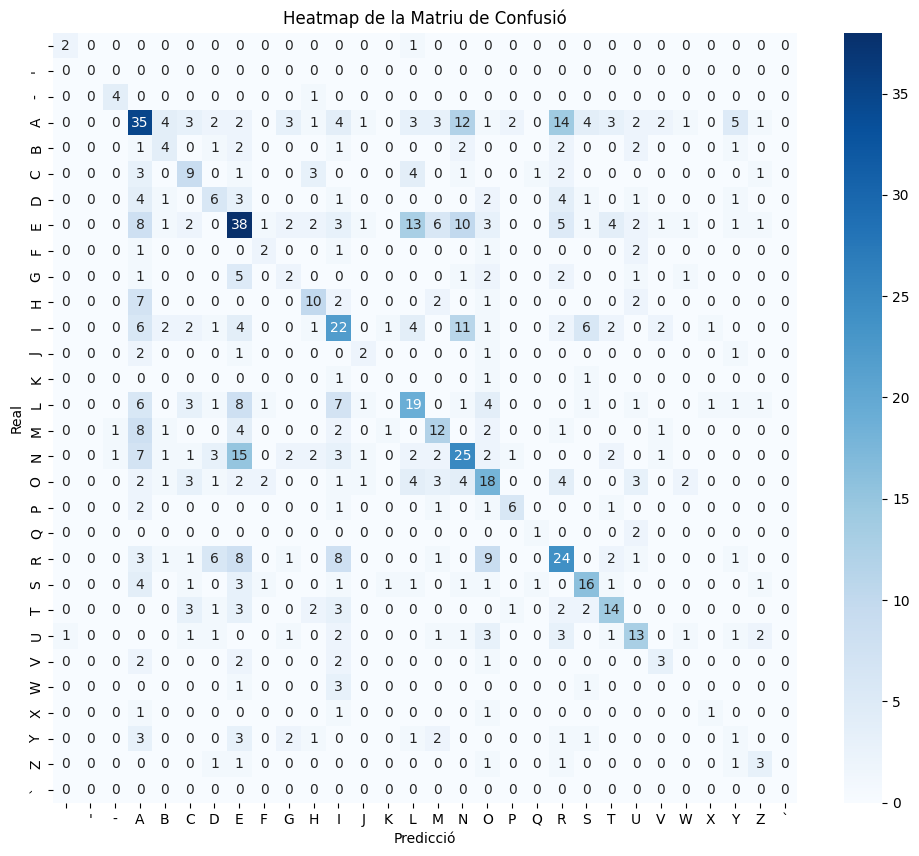

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

real = [char for label in orig_texts for char in label]
pred = [char for label in pred_texts for char in label]

#assegura que les dues llistes tinguin la mateixa longitud
min_length = min(len(real), len(pred))
real = real[:min_length]
pred = pred[:min_length]


conf_mat = confusion_matrix(real, pred, labels=list(characters))

plt.figure(figsize=(12, 10))
sns.heatmap(conf_mat, xticklabels=list(characters), yticklabels=list(characters), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicció')
plt.ylabel('Real')
plt.title('Heatmap de la Matriu de Confusió')
plt.show()

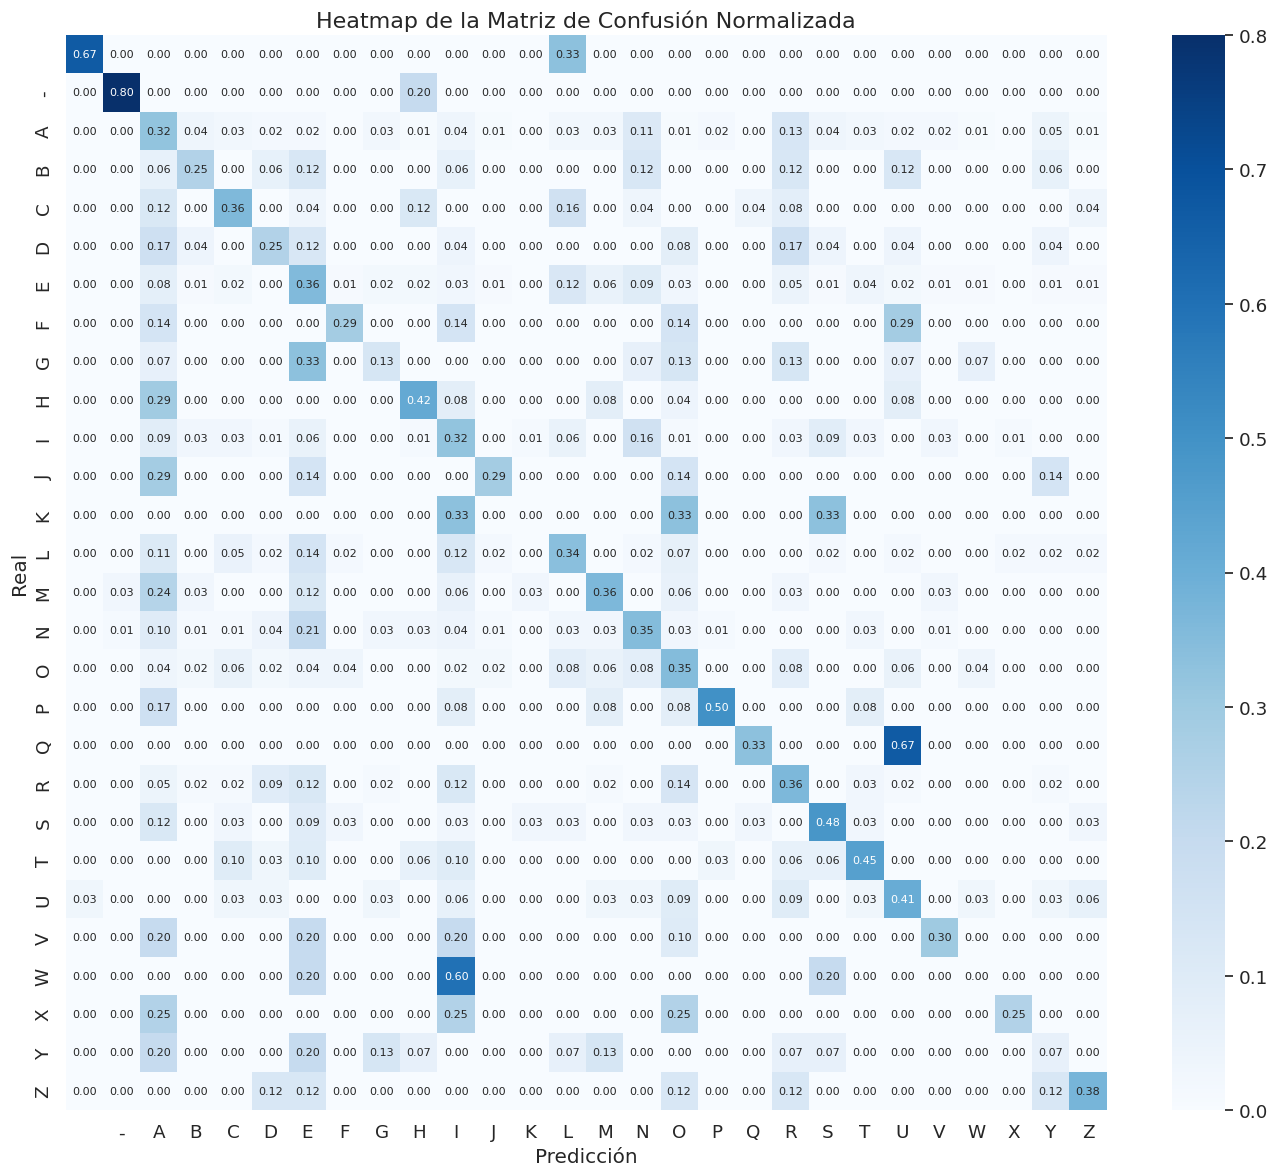

In [60]:
real = [char for label in orig_texts for char in label]
pred = [char for label in pred_texts for char in label]

#assegura que les dues llistes tinguin la mateixa longitud
min_length = min(len(real), len(pred))
real = real[:min_length]
pred = pred[:min_length]

characters = sorted(set(real + pred))

conf_mat = confusion_matrix(real, pred, labels=list(characters))

#normalitzar la matriu de confusió
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(conf_mat_norm, xticklabels=list(characters), yticklabels=list(characters), annot=True, fmt='.2f', cmap='Blues', annot_kws={"size": 8})
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Heatmap de la Matriz de Confusión Normalizada', fontsize=16)

plt.tight_layout()
plt.show()